## Вступ

У цьому проєкті ми працюємо з реальними бізнес-даними продажів мережі супермаркетів **Corporación Favorita**.  
Дані взяті з Kaggle-змагання  
[Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting).

До складу датасету входять кілька таблиць:
- **train.csv** — історичні щоденні продажі для кожного товару в кожному магазині  
- **items.csv** — інформація про товари  
- **oil.csv** — щоденні ціни на нафту (як зовнішній економічний фактор)  
- **stores.csv** — інформація про магазини  
- **transactions.csv** — кількість транзакцій у кожному магазині

У цьому проєкті ми використовуємо лише **train.csv**  
і **агрегуємо дані по днях**, щоб отримати один часовий ряд сукупних продажів компанії.

Дані охоплюють **період із 2013 по 2017 рік**,  
а метою є **побудова прогнозу продажів на наступні 3 місяці**.



##### Імпорт бібліотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

##### Зчитування датасету

In [3]:
df_train = pd.read_csv('data/train.csv', dtype={'onpromotion': str})

In [4]:
df_test = pd.read_csv('data/test.csv')

In [5]:
stores = pd.read_csv('data/stores.csv')
items = pd.read_csv('data/items.csv')

In [6]:
df_train = df_train.join(stores.set_index('store_nbr'), on='store_nbr')
df_test = df_test.join(stores.set_index('store_nbr'), on='store_nbr')

In [7]:
df_train.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
5,5,2013-01-01,25,108786,3.0,NaN,Salinas,Santa Elena,D,1
6,6,2013-01-01,25,108797,1.0,NaN,Salinas,Santa Elena,D,1
7,7,2013-01-01,25,108952,1.0,NaN,Salinas,Santa Elena,D,1
8,8,2013-01-01,25,111397,13.0,NaN,Salinas,Santa Elena,D,1
9,9,2013-01-01,25,114790,3.0,NaN,Salinas,Santa Elena,D,1


##### Оберешо штат Pichincha, приєднаємо item та зробимо очитку непотрібних стовпців

In [8]:
df_train = df_train[df_train['state'] == 'Pichincha']
df_test = df_test[df_test['state'] == 'Pichincha']

In [9]:
df_train = df_train.join(items.set_index('item_nbr'), on='item_nbr')
df_test = df_test.join(items.set_index('item_nbr'), on='item_nbr')

In [10]:
df_train.drop(columns=['type', 'cluster', 'state', 'class', 'perishable', 'store_nbr', 'item_nbr'], inplace=True)
df_test.drop(columns=['type','cluster','state', 'class', 'perishable', 'store_nbr', 'item_nbr'], inplace=True)

In [11]:
df_train['onpromotion'] = df_train['onpromotion'].fillna(False)
df_test['onpromotion'] = df_test['onpromotion'].fillna(False)

##### Згрупуємо кількість проданих товарів по даті

In [12]:
grouped = df_train.groupby(['date'])['unit_sales'].sum().reset_index()

In [13]:
grouped.head(20)

,date,unit_sales
0,2013-01-02,295729.012
1,2013-01-03,203589.568
2,2013-01-04,203090.766
3,2013-01-05,280222.420
4,2013-01-06,320453.744
5,2013-01-07,190027.840
6,2013-01-08,180195.921
7,2013-01-09,168336.198
8,2013-01-10,141711.915
9,2013-01-11,162328.716


##### Візуалізація

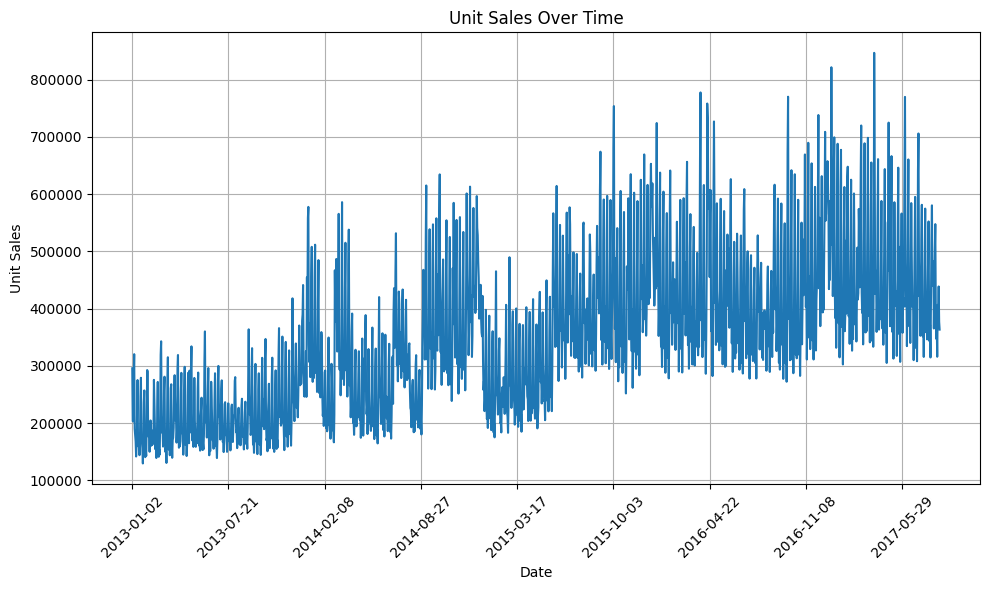

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(grouped['date'], grouped['unit_sales'])
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(grouped['date'][::200], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## Завдання проєкту


---

### Ваші кроки:

1. **Попередній аналіз**
   - Проведіть **сезонну декомпозицію** ряду (trend + seasonal + residual).  
   - Опишіть основні тренди, сезонність та можливі аномалії.  


3. **Побудова моделі**
   - Оберіть одну або кілька моделей для прогнозу (наприклад: ETS, ARIMA, Prophet).  
   - Навчіть модель на історичних даних.

4. **Прогнозування**
   - Побудуйте прогноз продажів на **наступні 3 місяці**.  
   - Візуалізуйте результати разом із історичними даними.

5. **Оцінка моделі**
   - Обчисліть метрики точності: `MAE`, `RMSE`, `MAPE`.  
   - Порівняйте результати кількох моделей (якщо їх кілька).

6. **Висновки**
   - Опишіть, які тенденції ви виявили.  
   - Яка модель показала найкращий результат і чому.  
   - Які чинники могли б покращити прогноз (наприклад, додаткові фічі або зовнішні дані).

---

> Якщо ви працюєте **локально**, можете використати всі сирі дані з Kaggle  
> (таблиці `train.csv`, `items.csv`, `oil.csv`, `stores.csv`, `transactions.csv`)  
> і виконати власну агрегацію або додати зовнішні ознаки.  
> Для цього перегляньте:
> - **Лекцію 3 — EDA (Exploratory Data Analysis)**
> - **Лекцію 5 — Feature Engineering**

In [16]:
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

###### Додамо ковзане середне і після візуалізуємо на графіку

In [17]:
df_train['onpromotion'] = df_train['onpromotion'].astype(int)
df_test['onpromotion'] = df_test['onpromotion'].astype(int)


grouped['rolling_mean_14'] = grouped['unit_sales'].transform(lambda x: x.shift(14).rolling(window=14).mean())

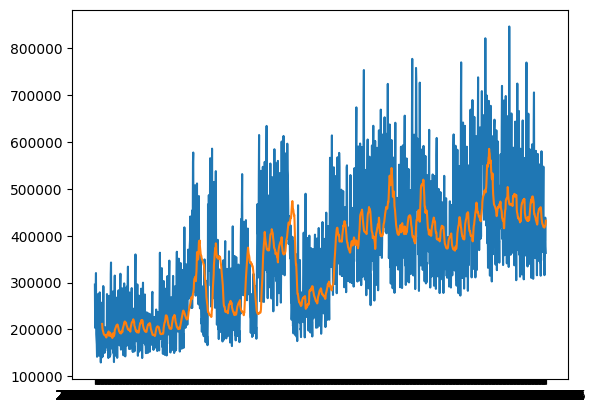

In [18]:
plt.plot(grouped['date'], grouped['unit_sales'])
plt.plot(grouped['date'], grouped['rolling_mean_14'], label='Rolling mean (14)')
plt.show()

###### Проведемо декомпозицію

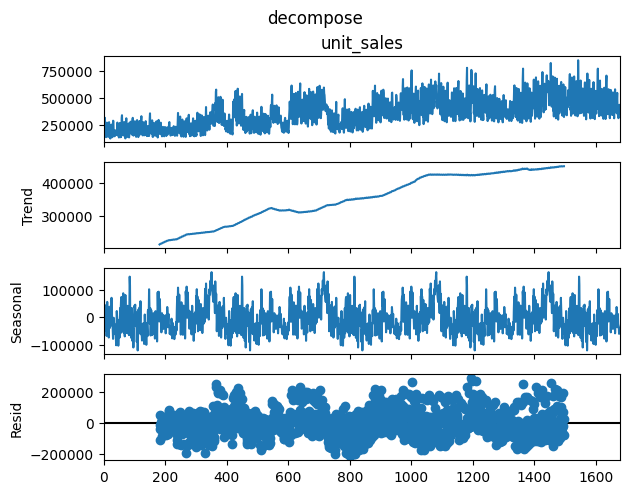

In [19]:
decomp_mul = seasonal_decompose(grouped['unit_sales'], period=365)
decomp_mul.plot()
plt.suptitle("decompose", y=1.02)
plt.show()

##### З графіків бачимо, що в датасеті є зростаючий тренд та виражена сезоонність

##### Для прогнозування даного датасету я оберу та порівняю дві модела - XGBoost та Prophet

###### Розширимо тестовий датасет для прогнозування на 3 місяці вперед

In [56]:
df_extended = grouped['date']
start_date = grouped['date'].max()
end_date = '2017-11-16'

df_extended = pd.DataFrame({
    'date': pd.date_range(start=start_date, end=end_date, freq='D')
})

In [39]:
grouped['date'] = pd.to_datetime(grouped['date'])
df_extended['date'] = pd.to_datetime(df_extended['date'])

###### Додамо фічі

In [57]:
grouped['year'] = grouped['date'].dt.year
grouped['month'] = grouped['date'].dt.month
grouped['day'] = grouped['date'].dt.day
grouped['dayofweek'] = grouped['date'].dt.day_of_week

df_extended['year'] = df_extended['date'].dt.year
df_extended['month'] = df_extended['date'].dt.month
df_extended['day'] = df_extended['date'].dt.day
df_extended['dayofweek'] = df_extended['date'].dt.day_of_week

features = ['year', 'month', 'day', 'dayofweek']

###### Створимо та визначимо найкращі параметри для моделі XGBoost

In [41]:
model = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=5, test_size=50)
param_grid = {'n_estimators': [20, 50, 100, 200],
              'max_depth':[3, 5, 7, 10],
              'learning_rate':[0.01, 0.05, 0.1, 0.2]
}
gridsearch_ = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, refit=True)

In [54]:
X_train, y_train = grouped[features], grouped['unit_sales']

In [55]:
gridsearch_.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [20, 50, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl... test_size=50)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [58]:
gridsearch_.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

###### Зробимо прогноз за допомогою XGBoost

In [59]:
predictions = gridsearch_.best_estimator_.predict(df_extended[features])

###### Перейдемо до моделі Prophet, для початку створимо додатковий датасет та перейменуємо стовпчики

In [60]:
df_prophet = grouped[['date','unit_sales']]
df_prophet.columns = ['ds','y']

###### Натренуємо Prophet модель з наступними показниками сезонності

In [61]:
prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True)

prophet.fit(df_prophet)

14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
prophet_pred_df_1 = prophet.make_future_dataframe(periods=30, freq = 'd')
prophet_pred_df_2 = prophet.make_future_dataframe(periods=61, freq = 'd')
prophet_pred_df_3 = prophet.make_future_dataframe(periods=91, freq = 'd')

###### Зробимо прогноз

In [63]:
prophet_predictions_1 = prophet.predict(prophet_pred_df_1)
prophet_predictions_2 = prophet.predict(prophet_pred_df_2)
prophet_predictions_3 = prophet.predict(prophet_pred_df_3)

##### Порівняннм моделей на візуалізації

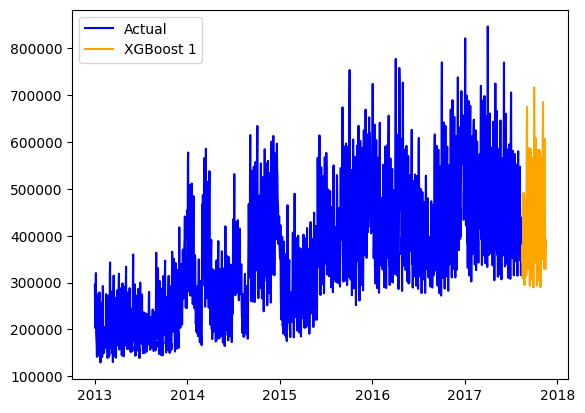

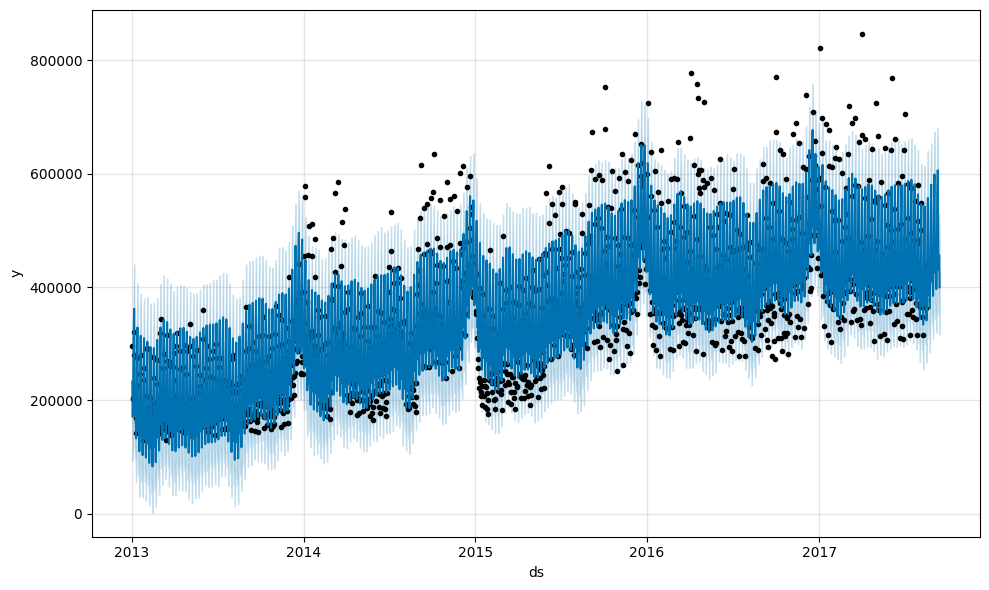

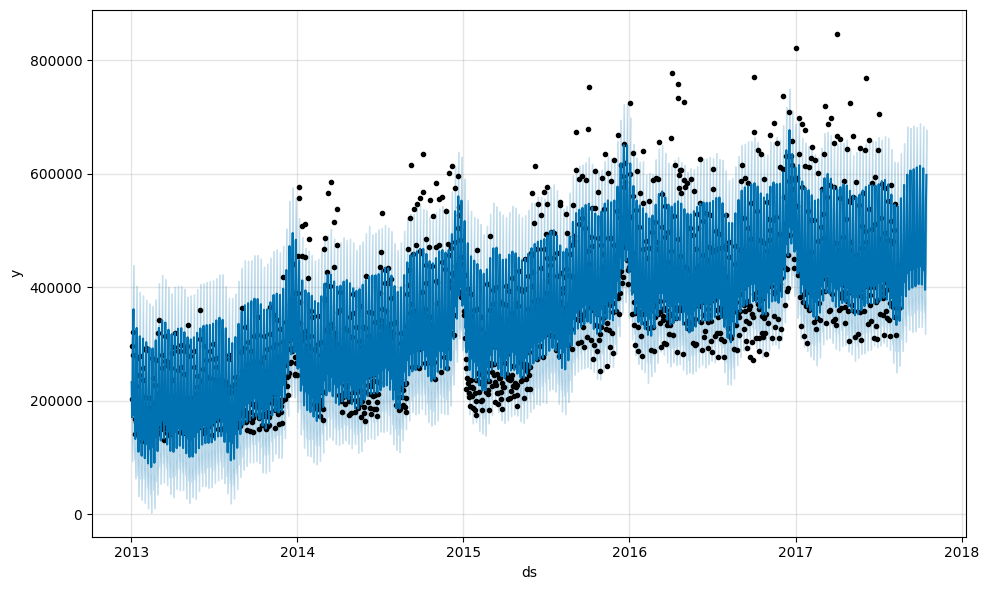

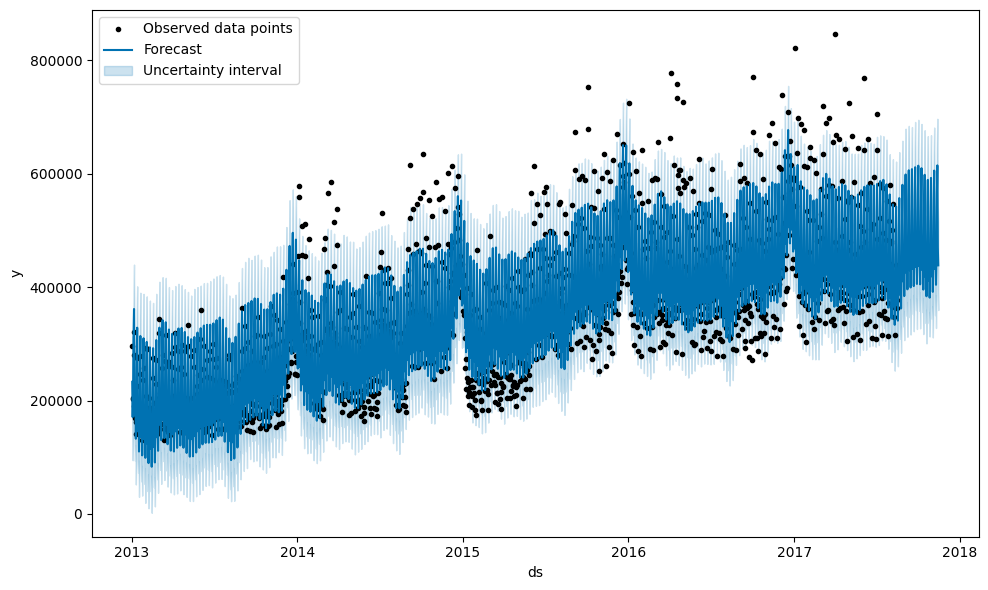

In [64]:
plt.plot(grouped['date'], grouped['unit_sales'], label='Actual', color='blue')
plt.plot(df_extended['date'], predictions, label='XGBoost 1', color='orange')
plt.legend()
prophet.plot(prophet_predictions_1)
prophet.plot(prophet_predictions_2)
prophet.plot(prophet_predictions_3)
plt.legend()
plt.grid()
plt.show()

##### Перерозподілимо датасет для обрахунку метрик

In [65]:
X_train, y_train = grouped[features][:-330], grouped['unit_sales'][:-330]
X_test, y_test = grouped[features][-330:], grouped['unit_sales'][-330:]

In [66]:
gridsearch_.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [20, 50, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl... test_size=50)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [67]:
prophet_model = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True)
prophet_model.fit(df_prophet[:len(X_train)])

14:57:55 - cmdstanpy - INFO - Chain [1] start processing
14:57:55 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
prophet_pred_df = prophet_model.make_future_dataframe(len(X_test)+2, freq='d')
prophet_preds = prophet_model.predict(prophet_pred_df)
prophet_preds.set_index('ds', inplace=True)

In [69]:
test_dates = df_prophet['ds'][len(X_train):]
test_dates = pd.to_datetime(test_dates)

y_pred = prophet_preds.loc[test_dates]['yhat']

In [70]:
print(f'XGBoost R2-score = {r2_score(y_test, gridsearch_.best_estimator_.predict(X_test))}')
print(f'XGBoost MSE = {mean_squared_error(y_test, gridsearch_.best_estimator_.predict(X_test))}')
print(f'XGBoost MAE = {mean_absolute_error(y_test, gridsearch_.best_estimator_.predict(X_test))}')

XGBoost R2-score = 0.531600811142307
XGBoost MSE = 5820029172.993565
XGBoost MAE = 55373.645288636355


In [71]:
print(f'Prophet R2-score = {r2_score(y_test, y_pred)}')
print(f'Prophet MSE = {mean_squared_error(y_test, y_pred)}')
print(f'Prophet MAE = {mean_absolute_error(y_test, y_pred)}')

Prophet R2-score = 0.5651204561291188
Prophet MSE = 5403535472.038625
Prophet MAE = 52231.03692440081


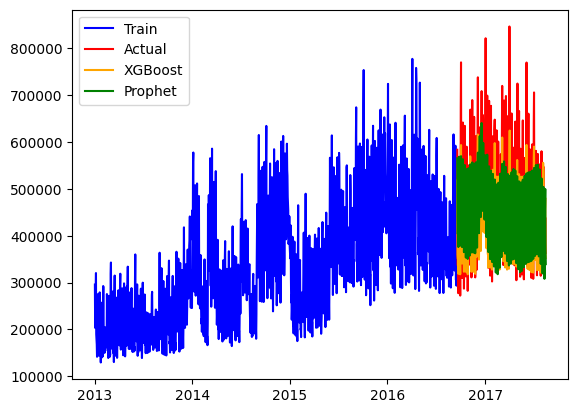

In [72]:
plt.plot(grouped['date'][:len(X_train)], y_train, label='Train', color ='blue')
plt.plot(test_dates, y_test, label='Actual', color ='red')
plt.plot(test_dates, gridsearch_.best_estimator_.predict(X_test), label='XGBoost', color ='orange')
plt.plot(test_dates, y_pred, label='Prophet', color ='green')
plt.legend()
plt.show()

In [73]:
grouped = pd.read_csv('data/grouped_data.csv')

In [74]:
import joblib
from pathlib import Path

In [75]:
artifact = {
    'model': gridsearch_.best_estimator_,
    'version': 1
}

In [76]:
MODELS_DIR = Path('models')
joblib.dump(artifact, MODELS_DIR / 'xgb_sales_model.pkl')

['models\\xgb_sales_model.pkl']